# ECG 5000 Project

In this project, we cover methodologies for reducing the dimensionality of continuous functions, specifically for ECG data. The project is an extension of work done in Professor Kamran Paynabar's class on High-Dimensional Data Analytics [2], but for multiclass modelling.

Continuous functions, as implied by their name, are types of data that have a continuous, or infinite nature. Some examples of continuous functions include signals and images. Many times, this data tends to be time-series in nature, so transforming this data to be machine-readable and efficient for classification tasks can seem challenging.

This notebook covers tools and tricks that can improve classification tasks for ECG data to detect variations in heart signals, which is vital for early detection of heart diseases. The data consists of 500 training samples and 4500 testing samples. The data for this project, and many others, can be downloaded from the following source:
https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/

Once you download the data, you have to figure out the secret password (it's not too difficult) to unlock the data. Let's dive right in!

### Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline
import seaborn as sns
from skfda.representation.basis import BSplineBasis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
                            roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.ndimage import gaussian_filter

%cd ~/GA_Tech/Projects/UCRArchive_2018/ECG5000

/Users/chai/GA_Tech/Projects/UCRArchive_2018/ECG5000


/Users/chai/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/chai/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
def lse_solver(X, y):
    return np.linalg.inv(X.T@X) @ X.T@y

def visualize_results(X_test, y_test, model):
    """Evaluates the performance of a model on testing data and visualizes the results in a dashboard format."""
    
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model accuracy: \033[1m{accuracy}\033[0m')

    conf_matrix = confusion_matrix(y_test, y_pred)
    
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    clf_df = pd.DataFrame(clf_report).transpose()
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    sns.heatmap(clf_df.iloc[:-1, :-1], annot=True, cmap='icefire', fmt='.2f', ax=axes[1])
    axes[1].set_title('Classification Report')

    plt.show()
    
    return clf_df.T

In [3]:
train = pd.read_csv('ECG5000_TRAIN.tsv', header=None, sep='\t').rename(columns={0:'y'})
test = pd.read_csv('ECG5000_TEST.tsv', header=None, sep='\t').rename(columns={0:'y'})
train['y'] = train['y'].astype(int)
test['y'] = test['y'].astype(int)

print('Training Data:')
display(train.shape, train.head(), train.describe())
print('\n\nTesting Data:')
display(test.shape, test.head(), test.describe())

Training Data:


(500, 141)

,y,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


,y,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,500.0000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.5240,-0.159100,-1.551951,-2.442733,-3.098292,-3.177269,-2.899259,-2.286133,-1.800159,-1.429717,...,0.146861,0.049037,-0.085459,-0.300097,-0.552943,-0.825774,-0.929637,-0.750090,-0.602488,-0.805451
std,0.7527,1.140292,1.416321,1.400143,1.325583,1.128045,0.904602,0.697134,0.575725,0.587910,...,1.132632,1.353449,1.594624,1.857173,2.025423,2.076705,2.106171,1.955936,1.946638,1.438395
min,1.0000,-3.694197,-5.117621,-5.110389,-5.060774,-5.375715,-5.056184,-3.960660,-3.066900,-2.906713,...,-3.072255,-3.560666,-4.006379,-4.212592,-4.526051,-5.150100,-4.872557,-4.959774,-5.639460,-5.797645
25%,1.0000,-0.928707,-2.644930,-3.617218,-4.251520,-4.022823,-3.537361,-2.779345,-2.182877,-1.786397,...,-0.608483,-0.965218,-1.485576,-2.038443,-2.654917,-3.075720,-3.032576,-2.315601,-1.970478,-1.663648
50%,1.0000,-0.216883,-1.539340,-2.513000,-3.309532,-3.541513,-3.008340,-2.298235,-1.761069,-1.438962,...,0.348091,0.438875,0.652819,0.585367,0.320551,-0.125691,-0.254106,-0.292570,-0.233793,-0.663025
75%,2.0000,0.582008,-0.595632,-1.448769,-2.199136,-2.546305,-2.432860,-1.847942,-1.489967,-1.108815,...,1.046332,1.147758,1.215568,1.239330,1.186627,1.016514,0.933622,0.960665,1.002865,0.222464
max,5.0000,4.058127,2.087844,1.592974,1.423006,1.014557,0.610640,0.778013,0.812531,1.136212,...,2.960969,2.602337,2.723053,2.912394,2.630759,2.852050,2.959741,2.613987,2.589474,2.854707




Testing Data:


(4500, 141)

,y,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,...,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073
1,1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,...,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009
2,1,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,...,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767
3,1,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,...,0.894638,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853
4,1,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,...,1.416582,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784


,y,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,...,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,1.527778,-0.273962,-1.660351,-2.497708,-3.121793,-3.166346,-2.862646,-2.271681,-1.797901,-1.407947,...,0.146259,0.073410,-0.060409,-0.273551,-0.502636,-0.753850,-0.824197,-0.630282,-0.474437,-0.694958
std,0.761301,1.153257,1.448446,1.384922,1.300375,1.101844,0.906330,0.735420,0.628203,0.642411,...,1.175640,1.410561,1.652410,1.899489,2.063698,2.087378,2.050563,1.848085,1.817460,1.411511
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.259295,-5.330194,-4.782240,-4.311288,-4.071361,...,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-4.911417,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.018202,-2.710514,-3.675967,-4.221921,-4.006748,-3.472986,-2.779941,-2.164166,-1.773173,...,-0.667551,-1.104062,-1.598281,-2.157220,-2.743237,-3.014821,-2.856324,-2.131719,-1.635179,-1.577515
50%,1.000000,-0.303240,-1.672456,-2.592071,-3.397653,-3.460329,-2.938500,-2.282163,-1.748535,-1.420713,...,0.481311,0.676028,0.732593,0.608052,0.335153,-0.025628,-0.180293,-0.191248,-0.144524,-0.551293
75%,2.000000,0.485655,-0.684776,-1.519119,-2.240458,-2.530796,-2.397532,-1.822741,-1.483616,-1.059521,...,1.064272,1.173172,1.239463,1.267172,1.237470,1.037941,0.947254,0.948825,1.002692,0.277078
max,5.000000,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,...,2.880345,3.007606,2.854680,2.912134,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103


### Visualizing the Data

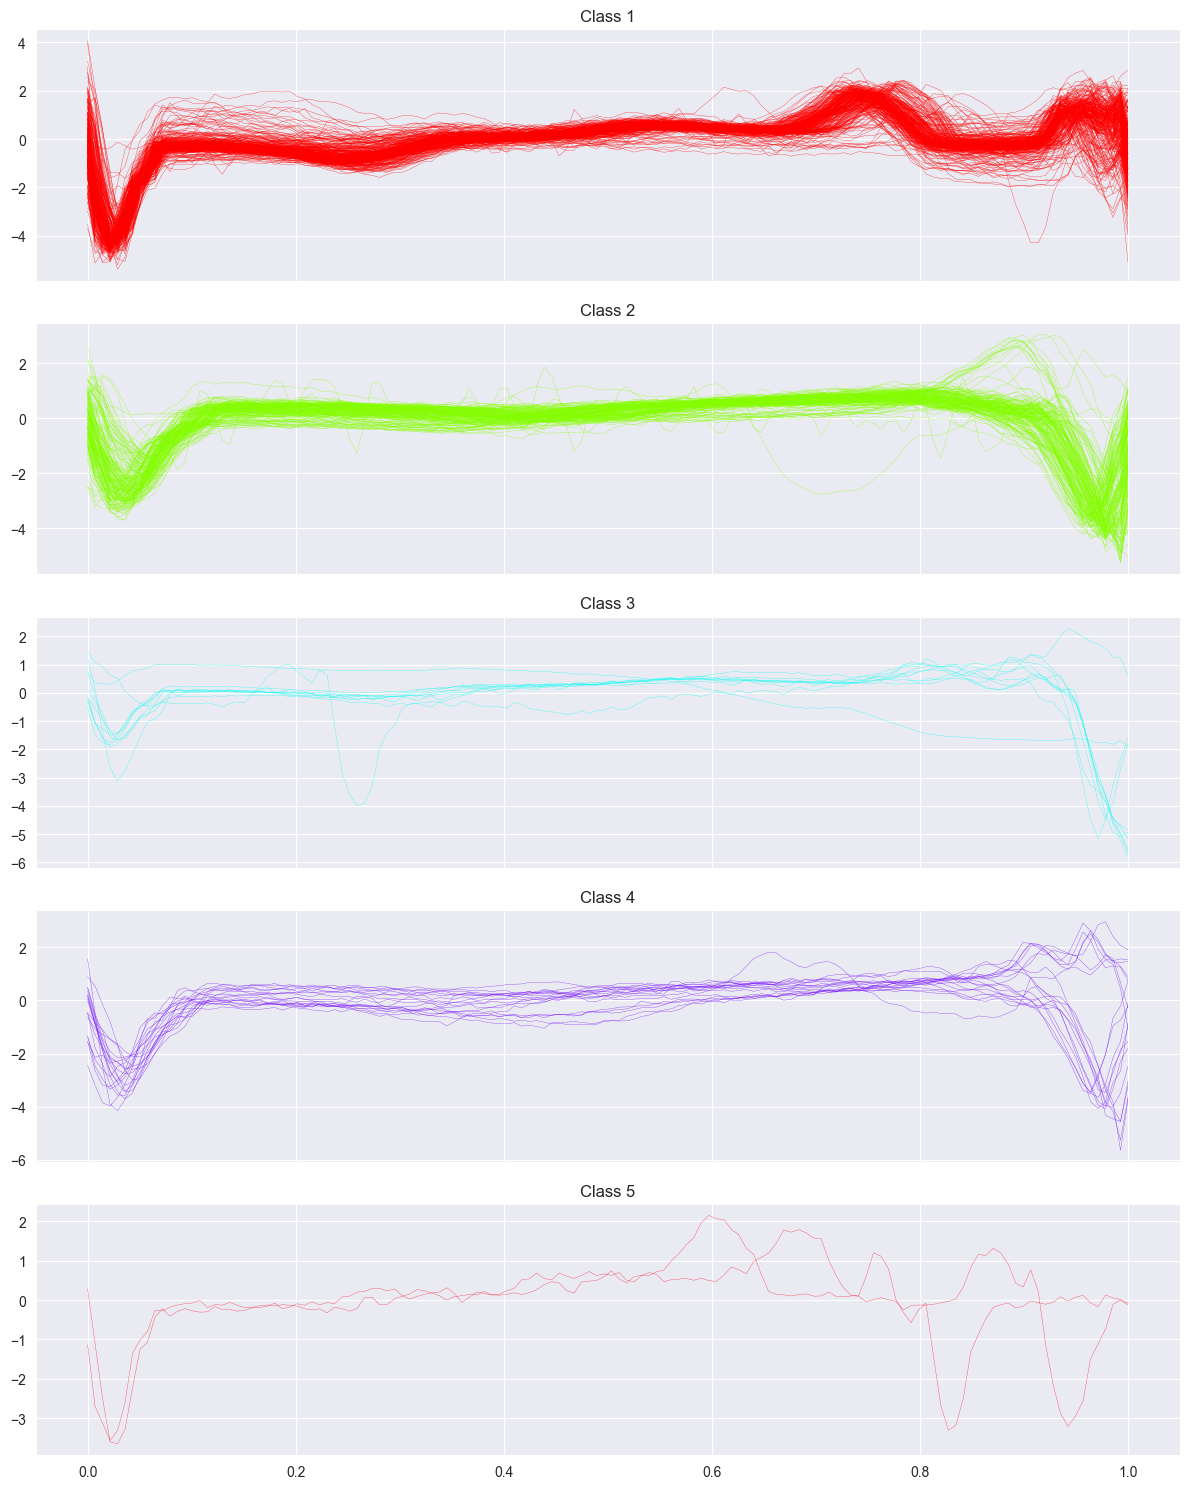

In [4]:
X_train = train.iloc[:, 1:]
y_train = train['y']
X_test = test.iloc[:, 1:]
y_test = test['y']

n_labels = len(np.unique(train['y']))

xx = np.linspace(0, 1, X_train.shape[1])

sns.set_style('darkgrid')
cmap = plt.get_cmap('hsv', n_labels)
fig, axes = plt.subplots(nrows=n_labels, sharex=True, figsize=(12, 3*n_labels))
for i in range(1, n_labels + 1):
    sns.set_style('darkgrid')
    axes[i-1].plot(xx, X_train[y_train==i].T, c=cmap(i-1), lw=0.2)
    axes[i-1].set_title(f'Class {i}')

plt.tight_layout()
plt.show()

### Basis Spline (B-Spline) Approach
B-Splines, or Basis Splines, are piece-wise polynomial approximations of a curve. They are defined recursively as such [1][2]:
$$
B_{i, j}(x) = \frac{x - t_i}{t_{i+j} - t_i} B_{i, j-1}(x) + \frac{t_{i+j+1} - x}{t_{i+j+1} - t_{i+1}} B_{i+1, j-1}(x)
$$

for $j \ge 1$ with the initial condition:

$$
B_i^0(x) =
\begin{cases}
1 & \text{if } t_i \le x < t_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$

Here:
- $B_{i, j}(x)$ is the B-Spline basis function of degree $k$.
- $x$ is the parameter.
- $t_i$ are the knots.

The B-Spline curve $C(x)$ of degree $j$ can be defined as a linear combination of these basis functions:

$$
C(t) = \sum_{i=0}^{n} P_i B_{i, j}(x)
$$

where $P_i$ are the control points.

Once we develop this feature space, we project the extracted feature space onto the B-Spline feature space, which effectively transforms the data into a lower dimensional approximation. For example, if we have $12$ knot, then no matter how many columns our data has, we would have knots + $2$, or $14$, columns.

Then, we can fit a simple SVC model to the data to get accuracy results for all the knot sequences.

#### Finding Optimal Number of Knots for B-Spline Basis

Optimal number of knots: 6


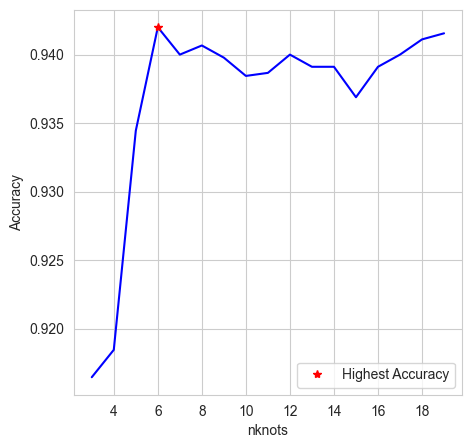

In [5]:
knots = []
accuracy_scores = []
order = 4
nknots = 6
for nknots in range(3, 20):
    k = np.linspace(0, 1, nknots)
    bs = BSplineBasis(knots=k, order=order)
    bs_basis = bs(xx).T[0]

    
    H_train = lse_solver(bs_basis, X_train.T).T
    H_test = lse_solver(bs_basis, X_test.T).T
    
    svc_model = SVC(probability=True, C=10, kernel='rbf', gamma='scale')
    svc_model.fit(H_train, y_train)
    y_pred = svc_model.predict(H_test)
    accuracy = accuracy_score(y_test, y_pred)
    knots.append(nknots)
    accuracy_scores.append(accuracy)

i = np.argmax(accuracy_scores)
nknots = knots[i]
print(f'Optimal number of knots: {nknots}')
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
plt.plot(knots, accuracy_scores, c='b')
plt.plot(nknots, accuracy_scores[i], 'r*', label='Highest Accuracy')
plt.xlabel('nknots')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Fitting Model with Optimal Number of Knots

Model accuracy: 0.9304444444444444


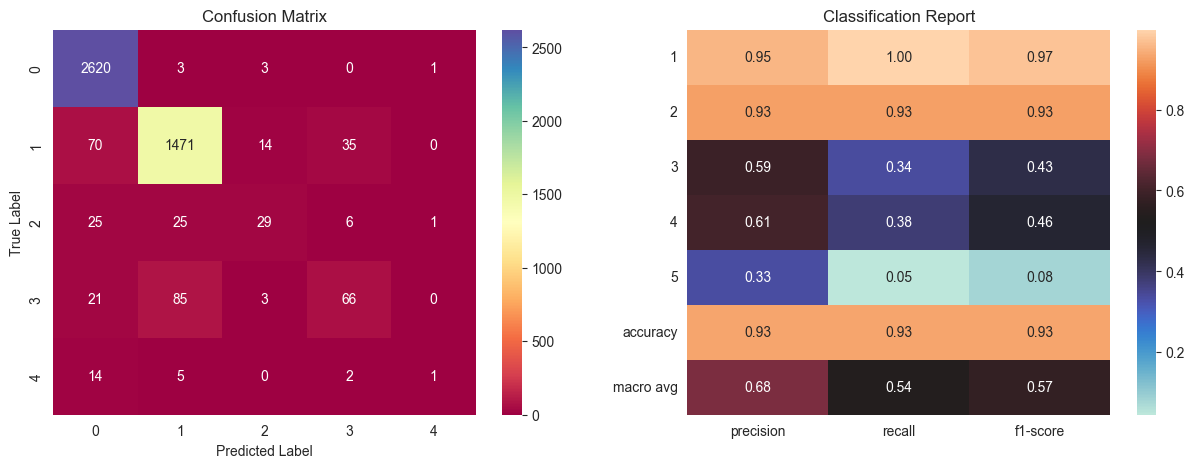

,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.952727,0.925739,0.591837,0.605505,0.333333,0.930444,0.681828,0.919763
recall,0.997335,0.925157,0.337209,0.377143,0.045455,0.930444,0.536460,0.930444
f1-score,0.974521,0.925448,0.429630,0.464789,0.080000,0.930444,0.574878,0.922572
support,2627.000000,1590.000000,86.000000,175.000000,22.000000,0.930444,4500.000000,4500.000000


In [6]:
k = np.linspace(0, 1, nknots)
bs = BSplineBasis(knots=k, order=order)
bs_basis = bs(xx).T[0]

H_train = lse_solver(bs_basis, X_train.T).T
H_test = lse_solver(bs_basis, X_test.T).T
svc_model = SVC(probability=True, C=10, kernel='poly', gamma='scale')
svc_model.fit(H_train, y_train)
y_pred = svc_model.predict(H_test)

visualize_results(H_test, y_test, svc_model)

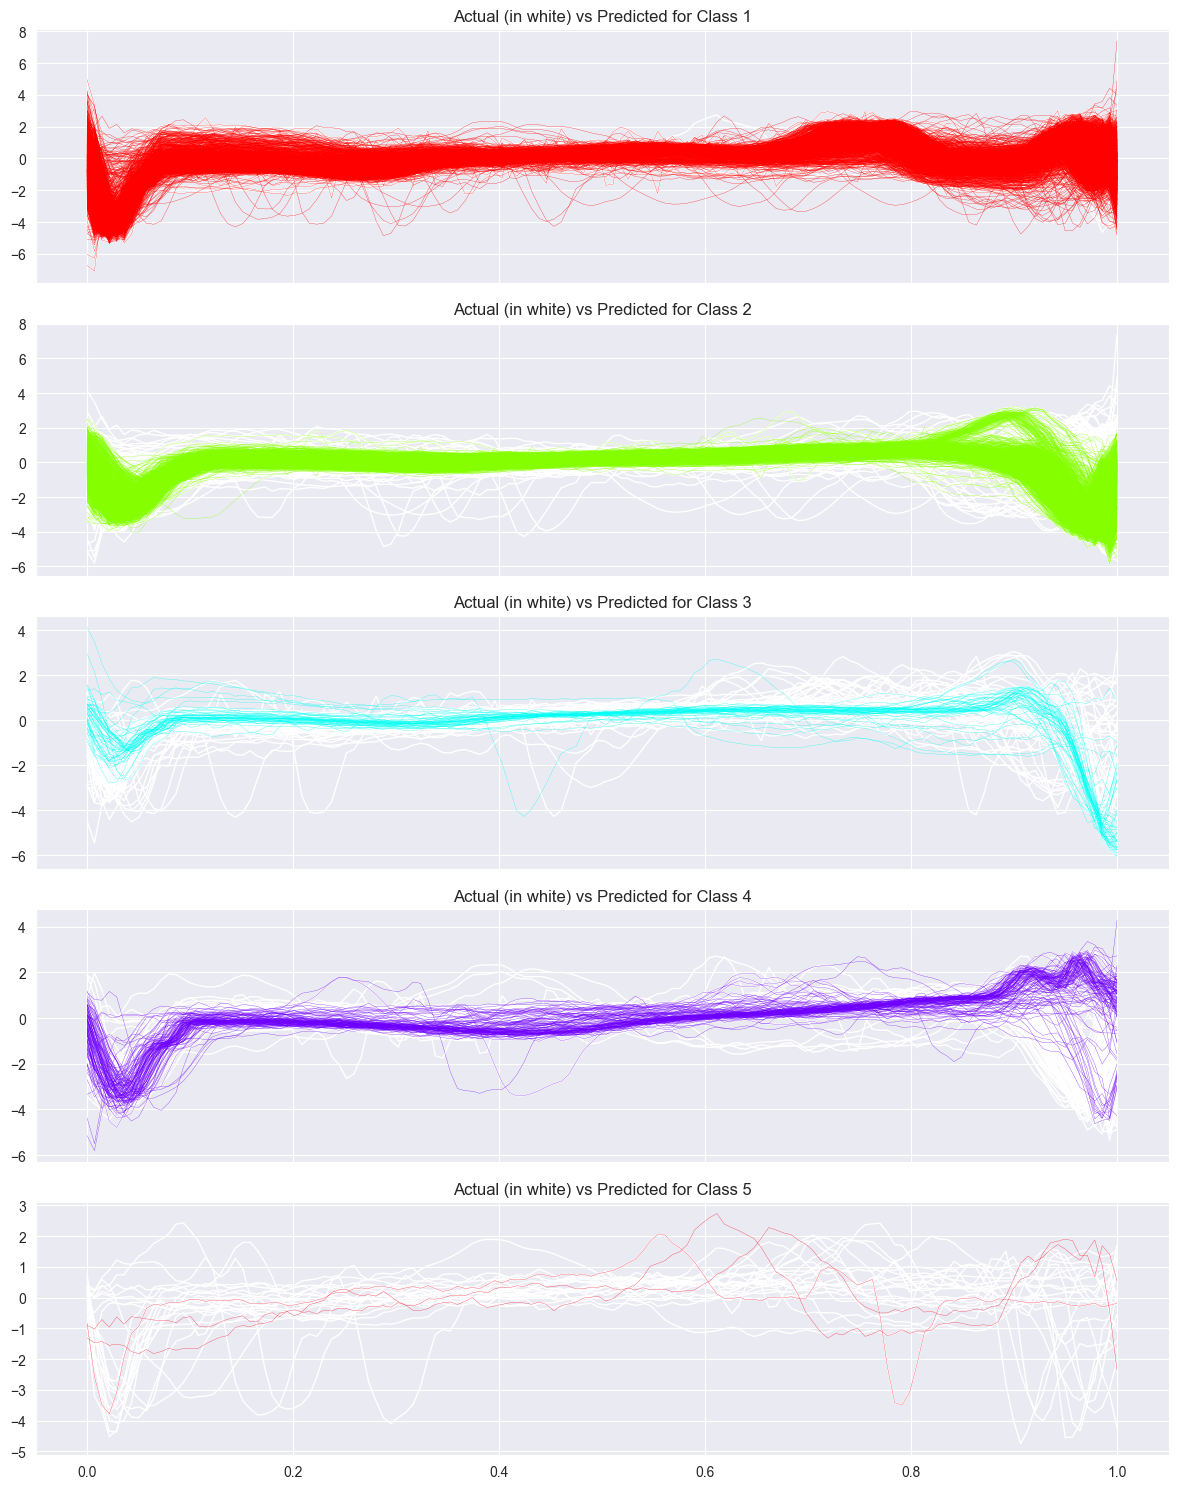

In [7]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=n_labels, sharex=True, figsize=(12, 3*n_labels))
for i in range(1, n_labels + 1):
    axes[i-1].plot(xx, X_test[y_test==i].T, c='white', lw=1)
    axes[i-1].plot(xx, X_test[y_pred==i].T, c=cmap(i-1), lw=0.2)
    axes[i-1].set_title(f'Actual (in white) vs Predicted for Class {i}')

plt.tight_layout()
plt.show()

### Functional Principal Component Analysis Approach (FPCA)
We can alternatively figure out what features explain the most variance in the functional data (functional principal components). This is the methodology [2]:

1.	Mean Function:
Compute the mean function $\mu$ via B-Spline basis, where $b$ represents a coefficient for the basis matrix and $X$. The mean function represents the dot product between the coefficients, or $\beta_{ols}$ of a stacked B-Spline basis matrix and $X$, across every point of and the basis matrix, $B$. $X_{stacked}$ is a flattened version of $X$ with dimensions $ = rows*columns$ x $1$. $B_{stacked}^{'}$ is equal to $B^{'}$ repeatedly stacked for each row of $X$. We then take the transpose of $B_{stacked}^{'}$ to get $B_{stacked}$.

$$
\beta_{ols} = B_{stacked} \cdot (B_{stacked}^{'} \cdot B_{stacked})^{-1} \cdot B_{stacked}^{'} \cdot X_{stacked}
$$

$$
\mu = B \cdot \beta_{ols}
$$

3.	Centered Functions:
Center the functions by subtracting the mean function:
$$
\tilde{X} = X - \mu
$$

4.	Covariance Function:
Compute the covariance function $C$:
$$
C = \frac{1}{n} (\tilde{X} \cdot \tilde{X}^{'})
$$

5.	Eigenfunctions and Eigenvalues:
Solve the eigenfunction problem for the covariance function:
$$
\int_a^b C \phi_k , d = \lambda_k \phi_k
$$
where $\lambda_k$ and $\phi_k$ are the $k$-th eigenvalue and eigenfunction, respectively.

6.	Principal Component Scores:
Compute the principal component scores $\xi_{k}$ for each function $X$:
$$
\xi_{k} = \int_a^b \tilde{X} \phi_k\ , d
$$

7.	Dimensionality Reduction:
Project $\tilde{X}$ onto the top $K$ components of $\phi_k$ to reduce the dimensionality of $X$:

$$
\tilde{X} \approx \tilde{X} \cdot \phi_k
$$

#### Computing Mean Functions

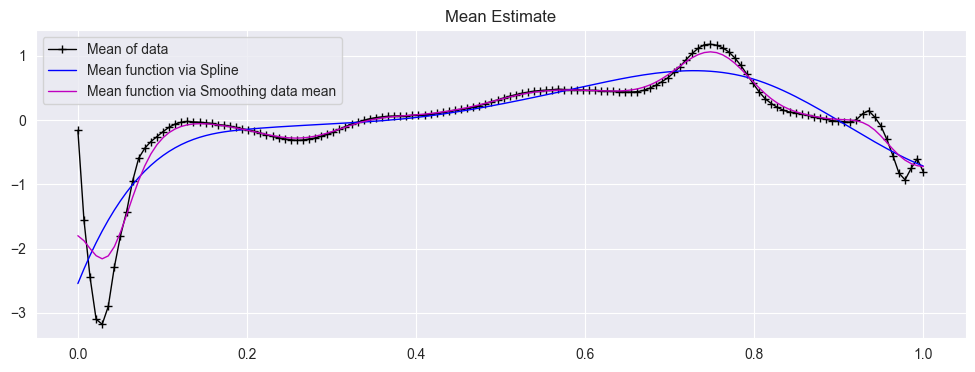

In [8]:
B_train_stacked = np.tile(bs_basis.T, len(train)).T
X_train_stacked = X_train.values.ravel()
beta = lse_solver(B_train_stacked, X_train_stacked)
mu_hat_train = bs_basis@beta
mu_hat_train2 = gaussian_filter(X_train.mean(0), 3)

B_test_stacked = np.tile(bs_basis.T, len(test)).T
X_test_stacked = X_test.values.ravel()
beta = lse_solver(B_test_stacked, X_test_stacked)
mu_hat_test = bs_basis@beta
mu_hat_test2 = gaussian_filter(X_test.mean(0), 3)


sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
plt.plot(xx, X_train.mean(0), 'k+-', lw=1, label='Mean of data')
plt.plot(xx, mu_hat_train, 'b', lw=1, label='Mean function via Spline')
plt.plot(xx, mu_hat_train2, 'm', lw=1, label='Mean function via Smoothing data mean')
plt.legend()
plt.title("Mean Estimate")
plt.show()

#### Covariance Function Computation

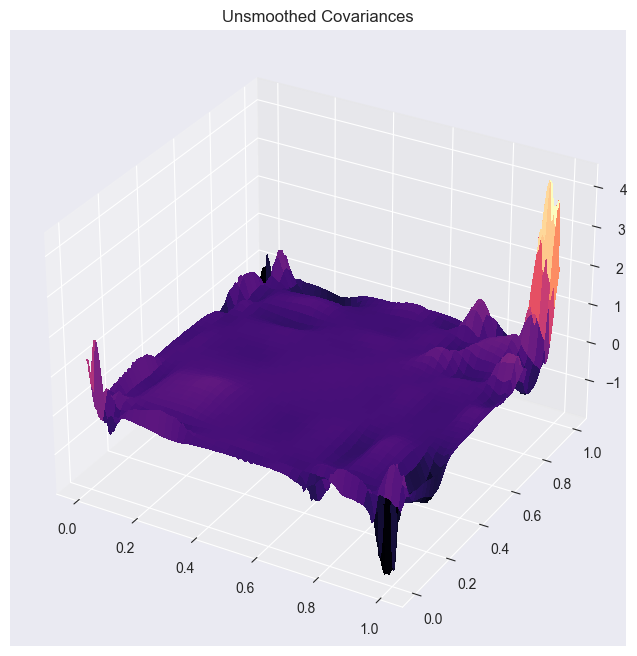

In [9]:
diffs_train = X_train-mu_hat_train
cov_train = np.cov(diffs_train.T)

diffs_test = X_test-mu_hat_test
cov_test = np.cov(diffs_test.T)

grids_train = np.meshgrid(xx, xx)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(grids_train[0], grids_train[1], cov_train, cmap='magma', lw=0, antialiased=False)
plt.title('Unsmoothed Covariances')
plt.show()

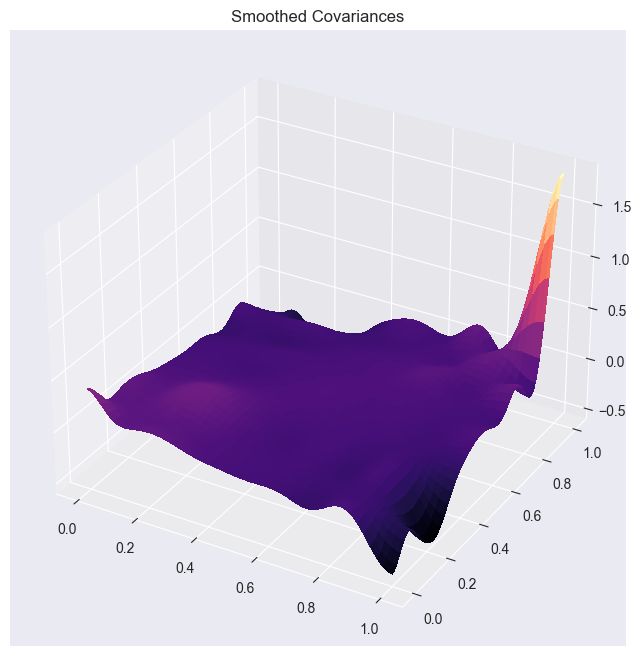

In [10]:
cov_train = gaussian_filter(cov_train, sigma=7)
cov_test = gaussian_filter(cov_test, sigma=7)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(grids_train[0], grids_train[1], cov_train, cmap='magma', lw=0, antialiased=False)
plt.title('Smoothed Covariances')
plt.show()

#### Finding Optimal Number of Principal Components using Eigenvalue Decomposition

Optimal number of principal components: 7


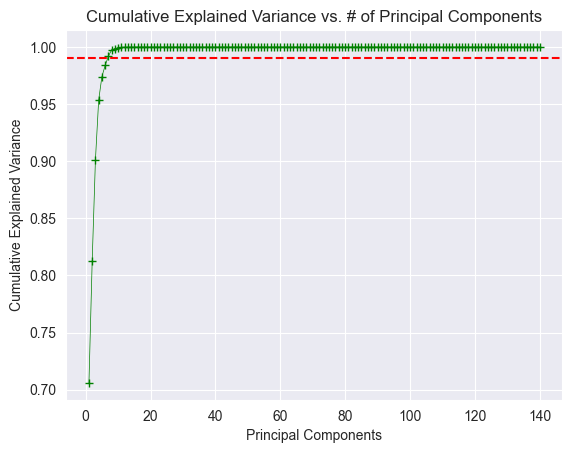

In [11]:
eig_v_train, eig_f_train = np.linalg.eigh(cov_train)
eig_v_test, eig_f_test = np.linalg.eigh(cov_test)

explained_variance_ratio = eig_v_train[::-1] / np.sum(eig_v_train)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

threshold = 0.99
optimal_num_pcs = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Optimal number of principal components: {optimal_num_pcs}")

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, lw=0.5, marker='+', c='g')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. # of Principal Components')
plt.show()

Model accuracy: 0.9328888888888889


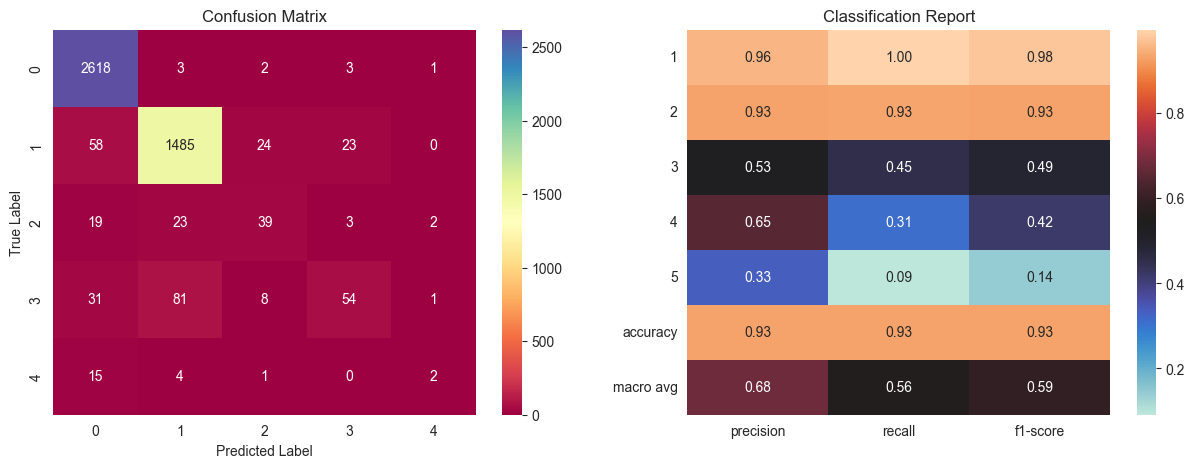

,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.955126,0.930451,0.527027,0.650602,0.333333,0.932889,0.679308,0.923344
recall,0.996574,0.933962,0.453488,0.308571,0.090909,0.932889,0.556701,0.932889
f1-score,0.975410,0.932203,0.487500,0.418605,0.142857,0.932889,0.591315,0.925095
support,2627.000000,1590.000000,86.000000,175.000000,22.000000,0.932889,4500.000000,4500.000000


In [12]:
PCs_train = eig_f_train[:, -optimal_num_pcs:]
FPC_train = diffs_train@PCs_train

PCs_test = eig_f_test[:, -optimal_num_pcs:]
FPC_test = diffs_test@PCs_test

svc_model = SVC(probability=True, C=10, kernel='rbf', gamma='scale')
svc_model.fit(FPC_train, y_train)
y_pred = svc_model.predict(FPC_test)
visualize_results(FPC_test, y_test, svc_model)

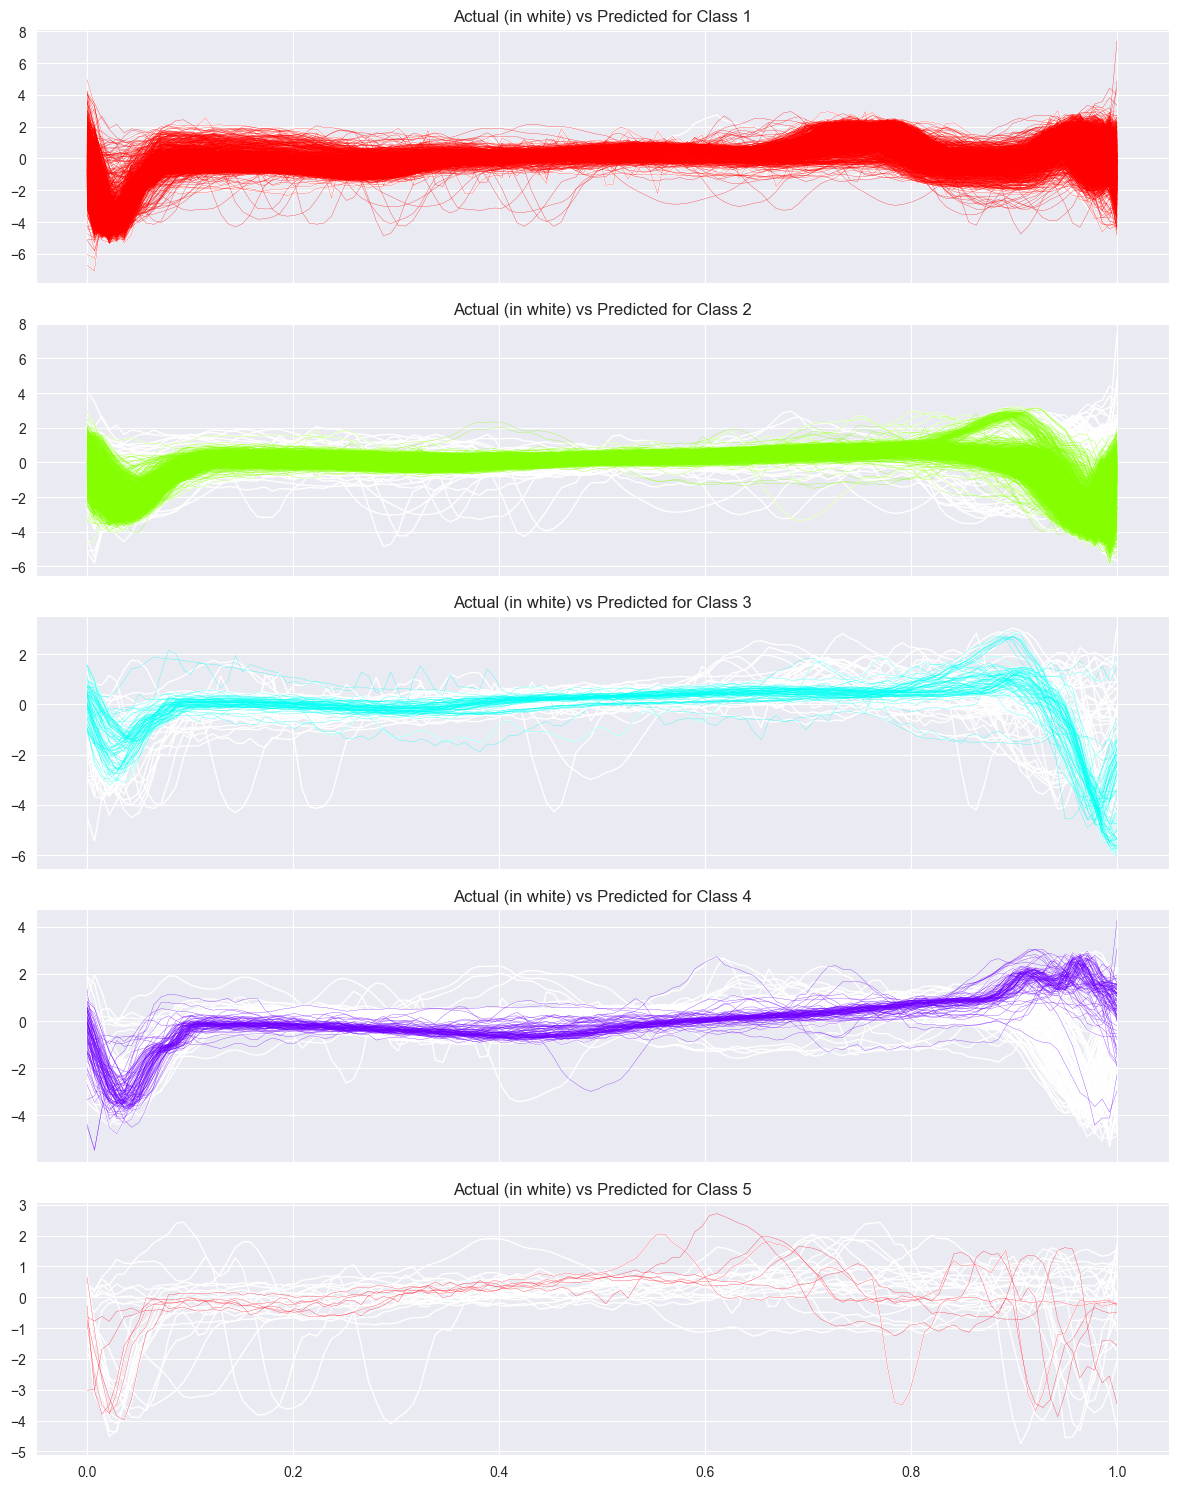

In [13]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=n_labels, sharex=True, figsize=(12, 3*n_labels))
for i in range(1, n_labels + 1):
    axes[i-1].plot(xx, X_test[y_test==i].T, c='white', lw=1)
    axes[i-1].plot(xx, X_test[y_pred==i].T, c=cmap(i-1), lw=0.2)
    axes[i-1].set_title(f'Actual (in white) vs Predicted for Class {i}')

plt.tight_layout()
plt.show()

### Obvervations/Results

Based on the results, both models performed extremely well at classifying classes 1 and 2. This is most likely because of the large sample sizes in these groups. Without sufficient information, the models will not be able to generalize and classify signals that belong to low sample size groups. Comparatively, both models did well, but the FPCA approach did slightly better with an accuracy of 93.28%. To increase the accuracy in the poor-performing groups, we can implement ensemble methods to amplify the strengths of both approaches, perform feature engineering to manipulate the ECG signals before applying dimensionality reduction, and we can utilize more robust models like neural networks.

### References:

[1] Hastie, T., Tibshirani, R., Friedman, J. (2009). Basis Expansions and Regularization. In: The Elements of Statistical Learning. Springer Series in Statistics. Springer, New York, NY. https://doi.org/10.1007/978-0-387-84858-7_5

[2] Paynabar, Kamran, "Intro to HD and Functional Data." Class lecture, High Dimensional Data Analytics, Georgia Institute of Technology, Atlanta, GA. May 13, 2024.